In [1]:
# !pip install transformers[torch]

In [2]:
# !python -c "from transformers import pipeline; print(pipeline('sentiment-analysis')('we love you'))"

In [11]:
# !pip install sent2vec

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\csala\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
import gensim, spacy
import gensim.corpora as corpora
from nltk.corpus import stopwords

import pandas as pd
import re
from tqdm import tqdm
import time

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this #rename gensim to gensim_models
# import matplotlib.pyplot as plt
# %matplotlib inline

## Setup nlp for spacy
nlp = spacy.load("en_core_web_sm")

In [14]:
# Load NLTK stopwords
stop_words = stopwords.words('english')
# Add some extra words in it if required
sw_custom=['bachelor', 'ba', 'msc', 'master', 'diploma','honors','hons','ma','science','year']
stop_words.extend(sw_custom)

In [16]:
name = 'field'
df=pd.read_excel(name+'.xlsx')
# Convert into list
data = df[0].values.tolist()

In [17]:
### Cleaning data

# Remove Emails
data = [re.sub('S*@S*s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\n', ' ', sent) for sent in data]
# Remove dash characters
data = [re.sub(' - ', ' ', sent) for sent in data]
# Remove single quotes
data = [re.sub("'", "", sent) for sent in data]
# Remove extra spaces
data = [re.sub("  ", " ", sent) for sent in data]
data = [re.sub("  ", " ", sent) for sent in data]
# Lower everything
# data = [sent.lower() for sent in data]

### Lemmatization
data_lemma = []
for txt in tqdm(data):
    lis = []
    doc = nlp(txt)
    for token in doc:
        lis.append(token.lemma_)
    data_lemma.append(' '.join(lis))

### Tokenization and gensim stopword removal

# You can look for all gensim stopwords by running -> 'gensim.parsing.preprocessing.STOPWORDS'

# Function to tokenize
# Also remove words whose length less than 3 (you can chang it)
def tokenization_with_gen_stop(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)

    return result

## Apply tokenization function
data_words = []
for txt in tqdm(data_lemma):
    data_words.append(tokenization_with_gen_stop(txt))

### NLTK Stopword removal (extra stopwords)

data_words_clean = []
for word in tqdm(data_words):
    wrd = []
    for w in word:
        if w not in stop_words:
            wrd.append(w)
    data_words_clean.append(wrd)

100%|██████████| 638/638 [00:00<00:00, 159132.13it/s]


In [18]:
from scipy import spatial
from sent2vec.vectorizer import Vectorizer

sentences = [' '.join(i) for i in data_words_clean[:]]

vectorizer = Vectorizer()
vectorizer.run(sentences)
vectors_bert = vectorizer.vectors

Initializing Bert distilbert-base-uncased
Vectorization done on cpu


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
df[1]=sentences

In [20]:
from sklearn.cluster import KMeans

k=10

est = KMeans(k)  # 4 clusters
X = vectors_bert
est.fit(X)
y_kmeans = est.predict(X)
df['cluster'] = y_kmeans

In [21]:
# !pip install wordcloud

In [22]:
import warnings

warnings.simplefilter("ignore")

Cluster 0 71 tokens


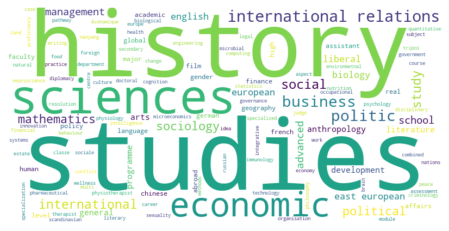

Cluster 1 74 tokens


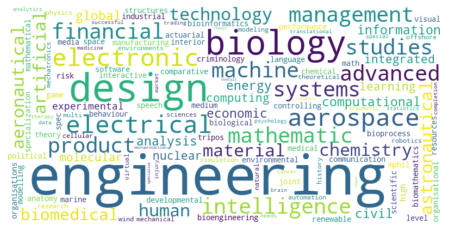

Cluster 2 94 tokens


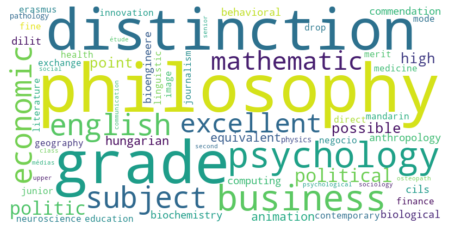

Cluster 3 90 tokens


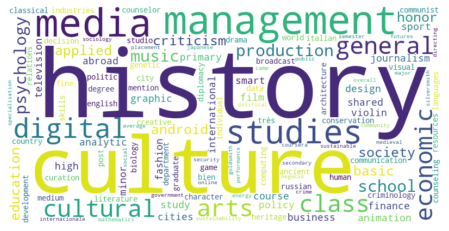

Cluster 4 1 tokens


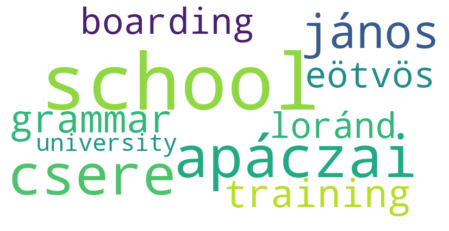

Cluster 5 124 tokens


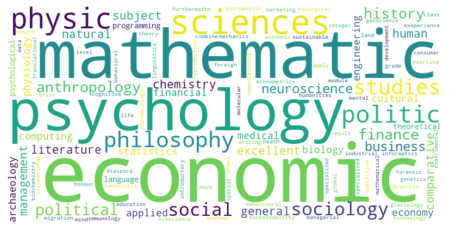

Cluster 6 89 tokens


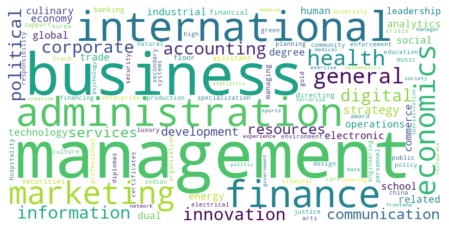

Cluster 7 23 tokens


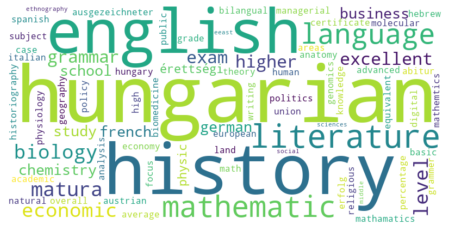

Cluster 8 59 tokens


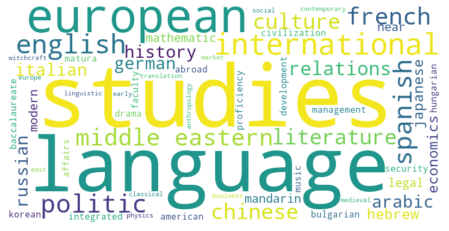

Cluster 9 13 tokens


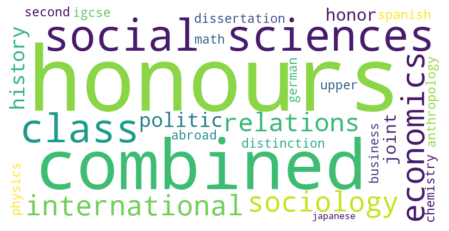

In [23]:
from wordcloud import WordCloud

for i in range(k):
    z = df[df['cluster'] == i][1].values
    z = [
        ' '.join([j.strip() for j in i.split(' ') if j.lower() not in sw_custom])
        for i in z
    ]
    print('Cluster',i,len(z),'tokens')
    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white", width=800,
                          height=400).generate(' '.join(z))

    import matplotlib.pyplot as plt

    plt.figure(figsize = (8,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


In [24]:
df.drop('Unnamed: 0',axis=1).to_excel(name+'.xlsx')